In [1]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.style.use("classic")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import QuantLib as ql 
import pandas as pd 
import numpy as np

First, raw option data for Tesla on January 15th, 2021 is loaded. The next few cells will perform some preprocessing on the data to get it into matrix form.<br/><br/>
No IV calculations will be done at all. Instead, the pre-computed IV values (labaled as "greeks.smv_vol") from Tradier are used.<br/>
Therefore, the actual data scope will be relatively small as "NaN" values will need to be accounted for. 

In [11]:
df = pd.read_csv("C:/Users/akbar/home/data/chains/TSLA/TSLA_210115.csv").drop(columns = ["description"])
df.head(5)

,Unnamed: 0,symbol,exch,type,last,change,volume,open,high,low,...,greeks.gamma,greeks.theta,greeks.vega,greeks.rho,greeks.phi,greeks.bid_iv,greeks.mid_iv,greeks.ask_iv,greeks.smv_vol,greeks.updated_at
0,0,TSLA210122P00350000,Z,option,0.02,NaN,162,0.01,0.03,0.01,...,-2.907950e-16,0.0,0.00002,0.0,0.0,1.82012,1.865070,1.91002,1.34,2021-01-15 20:56:39
1,1,TSLA210122C00350000,Z,option,489.55,NaN,6,501.90,501.90,489.55,...,-2.907950e-16,0.0,0.00002,0.0,0.0,0.00000,1.282356,2.56471,1.34,2021-01-15 20:56:39
2,2,TSLA210122P00360000,Z,option,0.01,NaN,457,0.01,0.05,0.01,...,-2.907950e-16,0.0,0.00002,0.0,0.0,1.76267,1.806297,1.84992,1.34,2021-01-15 20:56:39
3,3,TSLA210122C00360000,Z,option,479.90,NaN,6,491.90,491.90,479.90,...,-2.907950e-16,0.0,0.00002,0.0,0.0,0.00000,1.243234,2.48647,1.34,2021-01-15 20:56:39
4,4,TSLA210122P00370000,Z,option,NaN,NaN,0,NaN,NaN,NaN,...,-2.907950e-16,0.0,0.00002,0.0,0.0,1.70637,1.816401,1.92643,1.34,2021-01-15 20:56:39


Options with low volume are disregarded as they may provide misleading information.<br/>In this example, 25 is chosen as the cutoff, but this value is arbitrary.<br/><br/>
Similarly, a strike bound between 600 and 1200 is imposed to prevent deep out of the money contracts from skewing the data.<br/>Tesla's share price on January 15th was around $830.<br/><br/>
Unecessary columns are then removed and the index is reset.

In [3]:
df.where(df.volume >= 25, inplace = True)
df.dropna(subset = ["last", "change", "greeks.smv_vol"], inplace = True)
df = df[["strike", "expiration_date", "greeks.smv_vol"]]
df.columns = ["strike", "expiration", "IV"]
df = df.loc[df.strike.between(600, 1200)]
df.reset_index()

,index,strike,expiration,IV
0,98,600.0,2021-01-22,1.080
1,99,600.0,2021-01-22,1.080
2,101,602.5,2021-01-22,1.070
3,102,605.0,2021-01-22,1.059
4,106,610.0,2021-01-22,1.048
...,...,...,...,...
967,7249,600.0,2023-03-17,0.759
968,7257,800.0,2023-03-17,0.769
969,7261,900.0,2023-03-17,0.773
970,7265,1000.0,2023-03-17,0.774


Finally, the pivot table function is used to convert the data frame into an N x M matrix. 

As it turns out, the data is not consistent. Specifically, there are more "NaN" values as the expiration date goes farther out.<br/>
From here, the choice is between maximizing the number of strikes or the number of expirations.<br/>
In this example, the first route is taken and only the first 3 expiration dates are used.  

In [4]:
dfm = df.pivot_table(index = "strike", columns = "expiration", values = "IV")
dfm = dfm.iloc[:, 0:3]
dfm.dropna(inplace = True) 
dfm

expiration,2021-01-22,2021-01-29,2021-02-05
strike,,,
600.0,1.080,1.032,0.948
625.0,1.006,0.986,0.917
630.0,0.987,0.978,0.912
635.0,0.974,0.971,0.907
640.0,0.959,0.963,0.902
...,...,...,...
1140.0,0.940,0.947,0.900
1150.0,0.951,0.952,0.904
1160.0,0.959,0.958,0.908


Since QuantLib doesn't provide direct compatibility between libraries like NumPy and Pandas, the QuantLib Matrix object is needed to store the IV values.<br/>
Note than in the third line, the transpose of the IV matrix is taken to match QuantLib's class requirements.

In [5]:
expirations = dfm.columns.to_list()
strikes = dfm.index.to_list() 
IV = dfm.to_numpy().T

IV_mat = ql.Matrix(len(strikes), len(expirations))
for i in range(IV_mat.rows()):
    for k in range(IV_mat.columns()):
        IV_mat[i][k] = IV[k][i]

Here, the model is built. Using QuantLib's term structure helpers, both the dividend and risk-free rate curves can be modeled with ease.

In [6]:
counter = ql.Actual365Fixed()
calendar = ql.UnitedStates()
today = ql.Date.todaysDate() 
ql.Settings.instance().evaluationDate = today

div = 0.0
r = 0.01 

div_term = ql.YieldTermStructureHandle(ql.FlatForward(today, div, counter))
flat_term = ql.YieldTermStructureHandle(ql.FlatForward(today, r, counter))

expirations = [ql.Date(d, "%Y-%m-%d") for d in expirations] # convert to QuantLib dates

surface = ql.BlackVarianceSurface(today, calendar, expirations, strikes, IV_mat, counter) 

Get volatility from the variance surface given a strike and expiration pair.<br/>
The inputs must be within range of the given expiration dates and strike prices. 

In [7]:
for T in np.arange(0, .04, .01):          # expirations in years
    print("\nDays = %d" % int(T * 365))   

    for K in np.arange(650, 1000, 100.): 
        print("Strike = %d, Volatility = %.3f" % 
                (K, surface.blackVol(T, K)))


Days = 0
Strike = 650, Volatility = 0.930
Strike = 750, Volatility = 0.692
Strike = 850, Volatility = 0.617
Strike = 950, Volatility = 0.682

Days = 3
Strike = 650, Volatility = 0.935
Strike = 750, Volatility = 0.750
Strike = 850, Volatility = 0.701
Strike = 950, Volatility = 0.739

Days = 7
Strike = 650, Volatility = 0.947
Strike = 750, Volatility = 0.870
Strike = 850, Volatility = 0.863
Strike = 950, Volatility = 0.856

Days = 10
Strike = 650, Volatility = 0.938
Strike = 750, Volatility = 0.893
Strike = 850, Volatility = 0.895
Strike = 950, Volatility = 0.879


Visual comparison between actual and model-calculated volatility.<br/><br/>
The actual volatility consists of 10 randomly sampled points from the data frame earlier.<br/>
This is important, as many academic journals and research notebooks cherry-pick their actual values.<br/>
In reality, the surface is not completely accurate, as shown below. 

The graph shown is for options expiring on Feburary 5th, 2021 given that today is January 19th, 2021. 

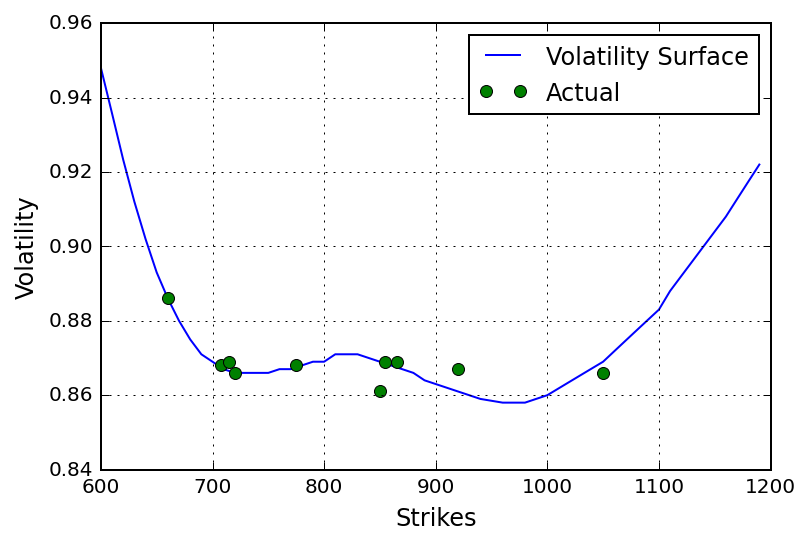

In [37]:
figure, axs = plt.subplots()

K = np.arange(600, 1200, 10.)
T = (ql.Date(5, 2, 2021) - today)/365
vols = [surface.blackVol(T, k) for k in K]

sample = np.random.choice(strikes, 10)
actual = dfm.loc[dfm.index.isin(sample), "2021-02-05"].to_numpy()

axs.plot(K, vols, label = "Volatility Surface")
axs.plot(sample, actual, "o", label = "Actual")

plt.xlabel("Strikes", size = 12)
plt.ylabel("Volatility", size = 12)
plt.legend()
plt.grid()
plt.show()

Below is a 3D-visual of the entire volatility surface. 

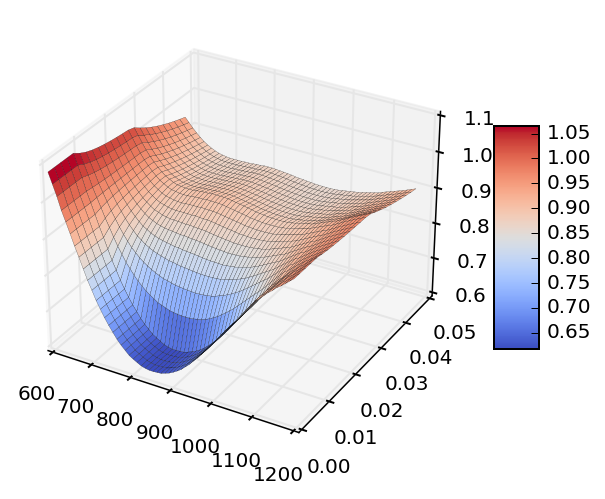

In [34]:
figure = plt.figure()

K_plot = np.arange(600, 1200, 10.)
T_plot = np.arange(0, T, 0.002)

axs = figure.gca(projection = "3d")
X, Y = np.meshgrid(K_plot, T_plot) 
Z = np.array([surface.blackVol(y, x) for xr, yr in zip(X, Y) for x, y in zip(xr, yr)]).reshape(len(X), len(X[0]))

surface_3d = axs.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = cm.coolwarm, linewidth = 0.1)
figure.colorbar(surface_3d, shrink = 0.5, aspect = 5)
plt.show()

Using a similar scheme, the local volatility surface can also be constructed given a spot price.<br/>For this example, the real spot price is used (830).

However, since our volatility surface is not arbitrage-free, the local volatility surface cannot be modeled accurately with the given data scope.<br/>
Aribtrage-free smoothing does exist; however, its implementation lacks in QuantLib. Even with more minimized strike and expiration bounds, the local surface looks... :/ 

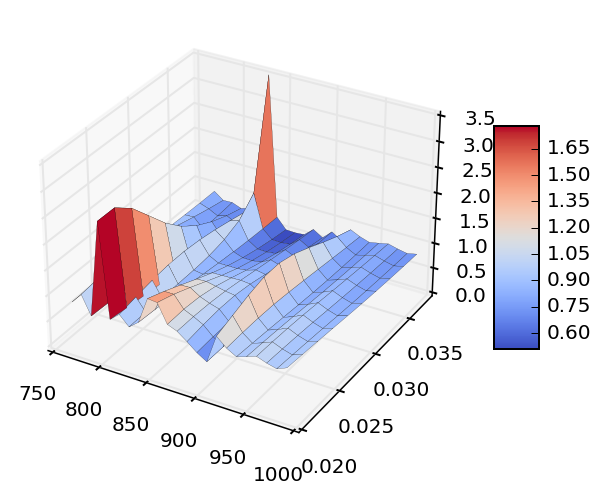

In [55]:
surface.setInterpolation("bicubic")
local_surface = ql.LocalVolSurface(ql.BlackVolTermStructureHandle(surface), flat_term, div_term, 830)

figure = plt.figure()

K_plot = np.arange(770, 1000, 10.)
T_plot = np.arange(0.02, .04, 0.002)

axs = figure.gca(projection = "3d")
X, Y = np.meshgrid(K_plot, T_plot) 
Z = np.array([local_surface.localVol(y, x) for xr, yr in zip(X, Y) for x, y in zip(xr, yr)]).reshape(len(X), len(X[0]))

surface_3d = axs.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = cm.coolwarm, linewidth = 0.1)
figure.colorbar(surface_3d, shrink = 0.5, aspect = 5)
plt.show()

Finally, the Heston model is constructed, calibrated and used to price option market quotes. 

Here, the Heston model is created with dummy parameters. 

In [72]:
surface.setInterpolation("bicubic")

sigma = 0.95
theta = 0.05
kappa = 0.2 
rho = -0.75 
V0 = 0.01 

model = ql.HestonModel(ql.HestonProcess(flat_term, div_term, ql.QuoteHandle(ql.SimpleQuote(830)), V0, kappa, theta, sigma, rho))
engine = ql.AnalyticHestonEngine(model) 

TTM = ql.Date(5, 2, 2021) - today 
period = ql.Period(TTM, ql.Days)
spot = 830 

heston_helpers = []
for i in dfm.iterrows():
    strike = i[0]
    IV = i[1][-1]

    IV_handle = ql.QuoteHandle(ql.SimpleQuote(IV))
    
    helper = ql.HestonModelHelper(period, calendar, spot, strike, IV_handle, flat_term, div_term)
    helper.setPricingEngine(engine) 
    heston_helpers.append(helper) 

Next, the Levenberg-Marquardt algorithm is used to calibrate (optimize) the model.

The calibrated parameters are shown. 

In [89]:
LM = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model.calibrate(heston_helpers, LM, ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, V0 = model.params()

print("theta = %.3f\nkappa = %.3f\nsigma = %.3f\n  rho = %.3f\n   V0 = %.3f\n" % (theta, kappa, sigma, rho, V0))

theta = 0.831
kappa = 165.273
sigma = 23.248
  rho = -0.036
   V0 = 0.344



Now, we can price option quotes. 

In [86]:
print("%15s %15s %15s %20s \n%s" % ("Strikes", "Market Value", "Model Value", "Relative Error (%)", "=" * 70))

average = 0.0
for idx, cal in enumerate(heston_helpers):
    MoV = cal.modelValue()
    MaV = cal.marketValue()
    error = (MoV/MaV - 1.0)
    average += abs(error)
    print("%15.2f %14.5f %15.5f %20.7f" % (strikes[idx], MoV, MaV, 100 * error))

average_error = (average * 100)/(len(heston_helpers))
print("%s\nAverage Abs Error (%%) : %5.3f" % ("=" * 70, average_error))

        Strikes    Market Value     Model Value   Relative Error (%) 
         600.00        5.96628         6.59534           -9.5379377
         625.00        8.40164         8.61002           -2.4201445
         630.00        8.97641         9.11085           -1.4755136
         635.00        9.58328         9.63519           -0.5387550
         640.00       10.22351        10.18389            0.3890222
         650.00       11.60913        11.39793            1.8529329
         660.00       13.14354        12.81178            2.5894975
         670.00       14.83706        14.40479            3.0008341
         675.00       15.74669        15.25592            3.2169551
         680.00       16.69994        16.19415            3.1232991
         685.00       17.69807        17.22527            2.7447800
         690.00       18.74230        18.19721            2.9954418
         695.00       19.83385        19.31813            2.6696179
         697.50       20.39775        19.92401